In [ ]:
# Define where you are running the code: colab or local
RunInColab          = True     # (False: no  | True: yes)

# If running in colab:
if RunInColab:
    # Mount your google drive in google colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Find location
    #!pwd
    #!ls
    #!ls "/content/drive/My Drive/Colab Notebooks/MachineLearningWithPython/"

    # Define path del proyecto
    Ruta            = "/content/drive/My Drive/Colab Notebooks/"

else:
    # Define path del proyecto
    Ruta            = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Describir de donde salieron estos datos ya que son diferentes a los que usa Oracle

In [ ]:
# Import the packages that we will be using
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset url
url = Ruta + "F1Stats_withWeather_filtered.csv"

# Load the dataset
dataset = pd.read_csv(url)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import time
start = time.time()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
plt.style.use('seaborn')

np.set_printoptions(precision=4)

## Read data

In this dataset, wins, points, constructorPoints, constructorWins, pitStops and pitDuration are shifted by 1 position, because we don't want the model to know present information, only the races before it

In [ ]:
data = dataset
data['date'] = pd.to_datetime(data['date'])

In [ ]:
len(data)

4699

In [ ]:
data.head()

Unnamed: 0  year       date                GP_name  raceId  circuitId  \
0           0  2011 2011-03-27  Australian Grand Prix     841          1   
1           1  2011 2011-03-27  Australian Grand Prix     841          1   
2           2  2011 2011-03-27  Australian Grand Prix     841          1   
3           3  2011 2011-03-27  Australian Grand Prix     841          1   
4           4  2011 2011-03-27  Australian Grand Prix     841          1   

   driverId  constructorId             driver  constructor  ...  pitDuration  \
0         1              1     Lewis Hamilton      McLaren  ...          0.0   
1       816            166  Jérôme d'Ambrosio       Virgin  ...          0.0   
2       814             10      Paul di Resta  Force India  ...          0.0   
3       808              4      Vitaly Petrov      Renault  ...          0.0   
4       153              5  Jaime Alguersuari   Toro Rosso  ...          0.0   

               GP_name.1  constructor_dnf  driver_dnf  \
0  Australian Grand Prix                0           0   
1  Australian Grand Prix                0           0   
2  Australian Grand Prix                0           0   
3  Australian Grand Prix                0           0   
4  Australian Grand Prix                0           0   

   constructor_reliability  driver_confidence weather   rain   snow  cloudy  
0                      0.0                0.0    12.2  False  False      16  
1                      0.0                0.0    12.2  False  False      16  
2                      0.0                0.0    12.2  False  False      16  
3                      0.0                0.0    12.2  False  False      16  
4                      0.0                0.0    12.2  False  False      16  

[5 rows x 29 columns]

In [ ]:
new_test = data["driver_dnf"]
new_test.head

<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
4694    0
4695    0
4696    0
4697    0
4698    0
Name: driver_dnf, Length: 4699, dtype: int64>

In [ ]:
data['year'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022])

Si utilizan datos del 2023, por que al entrenar los modelos no usan el archivo data_filtered_2021.csv, usan el data_filtered.csv
Esto ya no aplica, era en el otro. Confirmar que así sea y borrar

## Do data transformations

Informacion en la v1 de este notebook

In [ ]:
# dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
# constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
# constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
# constructor_reliability = 1-constructor_dnf_ratio
# constructor_reliability_dict = dict(zip(constructor_reliability.index,constructor_reliability))

In [ ]:
# dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
# driver_race_entered = data.groupby('driver').count()['driver_dnf']
# driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
# driver_confidence = 1-driver_dnf_ratio
# driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

Estas dos variables las calculamos agarrando solo dos años antes de la carrera presente, y los hacemos en el notebook de fix_f1_data_v1.ipynb

In [ ]:
# data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
# data['constructor_reliability'] = data['constructor'].apply(lambda x:constructor_reliability_dict[x])

In [ ]:
#removing retired drivers and constructors
active_constructors = ['Alpine F1', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Mick Schumacher', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Yuki Tsunoda',
                  'Max Verstappen', 'Pierre Gasly', 'Fernando Alonso',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Nikita Mazepin','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

La variable de dnf no se usaria para entrenar el modelo directamente, porque esta ya nos da la información de si acabo la carrera o no

In [ ]:
import os
if not os.path.exists('./models'):
    os.mkdir('./models')

In [ ]:
data.dtypes

Unnamed: 0                          int64
year                                int64
date                       datetime64[ns]
GP_name                            object
raceId                              int64
circuitId                           int64
driverId                            int64
constructorId                       int64
driver                             object
constructor                        object
position                            int64
quali_pos                           int64
wins                              float64
points                            float64
constructorPoints                 float64
constructorWins                   float64
driver_home                        object
statusId                            int64
pitStops                          float64
pitDuration                       float64
GP_name.1                          object
constructor_dnf                     int64
driver_dnf                          int64
constructor_reliability           

## Study the positions (y) and qualification position variables

In [ ]:
def position_index(x):
    if x < 4:
        return 0 # 1
    if x > 10:
        return 2 # 3
    else:
        return 1 # 2

In [ ]:
# pearson’, ‘kendall’, ‘spearman
def showCorrelation(data, nCols):
    methods=["pearson", "kendall", "spearman"]

    fig, axes = plt.subplots(nrows=len(methods), ncols=nCols, figsize=(5 * len(methods), 20))

    for i, method in enumerate(methods):
        ax = axes[i]
        corr = data.corr(method=method)
        sns.heatmap(corr, annot=True, ax=ax)
        ax.set_title(f'{method.capitalize()} Correlation')

    plt.tight_layout()
    plt.show()

In [ ]:
def factorizeColumns(data, colName, factColName):
    data[factColName] = pd.factorize(data[colName])[0]
    data[factColName].head

In [ ]:
def graph_diff_pos_quali_pos(all_gps_year, all_year_data):
  ncols = 2
  nrows = (len(all_gps_year) + 1) // ncols

  fig, axes = plt.subplots(nrows, ncols, figsize=(20, 70))

  for index, race in enumerate(all_gps_year.iterrows()):
      race = race[1]
      ax = axes[index // ncols, index % ncols]

      race_name = race['GP_name']
      race_date = race['date']
      race_data = all_year_data[all_year_data['GP_name'] == race_name]

      unique_race = race_data[race_data['date'] == race_date]
      
      ax.scatter(unique_race["driver"], unique_race["quali_pos"], color='k')
      ax.scatter(unique_race["driver"], unique_race["position"], color='g')

      ax.set_xticklabels(unique_race["driver"], rotation=90)
      ax.set_title(f"Grand prix {race_name}, {race_date}")

  plt.tight_layout()
  plt.show()

In [ ]:
data["active_driver"].head()

0    1
1    0
2    0
3    0
4    0
Name: active_driver, dtype: int64

In [ ]:
temp = data["driver"].unique()
len(temp)

70

In [ ]:
year2020 = data[data["year"] == 2020]
races = year2020["GP_name"].unique()

In [ ]:
all_gps_2020 = year2020[['GP_name', 'date']].drop_duplicates()

In [ ]:
race_data_temp = year2020[year2020['GP_name'] == races[0]]

race_data_temp[['position', 'quali_pos', 'driver', 'constructor', 'date']]

position  quali_pos              driver   constructor       date
3579         9         18  Antonio Giovinazzi    Alfa Romeo 2020-07-05
3580        13          4     Alexander Albon      Red Bull 2020-07-05
3581        15         17      George Russell      Williams 2020-07-05
3582         3          3        Lando Norris       McLaren 2020-07-05
3583         2          7     Charles Leclerc       Ferrari 2020-07-05
3584         7         12        Pierre Gasly    AlphaTauri 2020-07-05
3585         8         14        Esteban Ocon       Renault 2020-07-05
3586        11         20     Nicholas Latifi      Williams 2020-07-05
3587        12         13        Daniil Kvyat    AlphaTauri 2020-07-05
3588         4          5      Lewis Hamilton      Mercedes 2020-07-05
3589        14         19      Kimi Räikkönen    Alfa Romeo 2020-07-05
3590        10         11    Sebastian Vettel       Ferrari 2020-07-05
3591         5          8        Carlos Sainz       McLaren 2020-07-05
3592         6          6        Sergio Pérez  Racing Point 2020-07-05
3593         1          1     Valtteri Bottas      Mercedes 2020-07-05
3594        16         15     Romain Grosjean  Haas F1 Team 2020-07-05

In [ ]:
print(all_gps_2020)

                          GP_name       date
3579          Austrian Grand Prix 2020-07-05
3595           Styrian Grand Prix 2020-07-12
3613         Hungarian Grand Prix 2020-07-19
3633           British Grand Prix 2020-08-02
3650  70th Anniversary Grand Prix 2020-08-09
3670           Spanish Grand Prix 2020-08-16
3690           Belgian Grand Prix 2020-08-30
3707           Italian Grand Prix 2020-09-06
3726            Tuscan Grand Prix 2020-09-13
3740           Russian Grand Prix 2020-09-27
3758             Eifel Grand Prix 2020-10-11
3777        Portuguese Grand Prix 2020-10-25
3797    Emilia Romagna Grand Prix 2020-11-01
3816           Turkish Grand Prix 2020-11-15
3836           Bahrain Grand Prix 2020-11-29
3855            Sakhir Grand Prix 2020-12-06
3873         Abu Dhabi Grand Prix 2020-12-13


### Graph the difference in qualification position and position in the year 2020

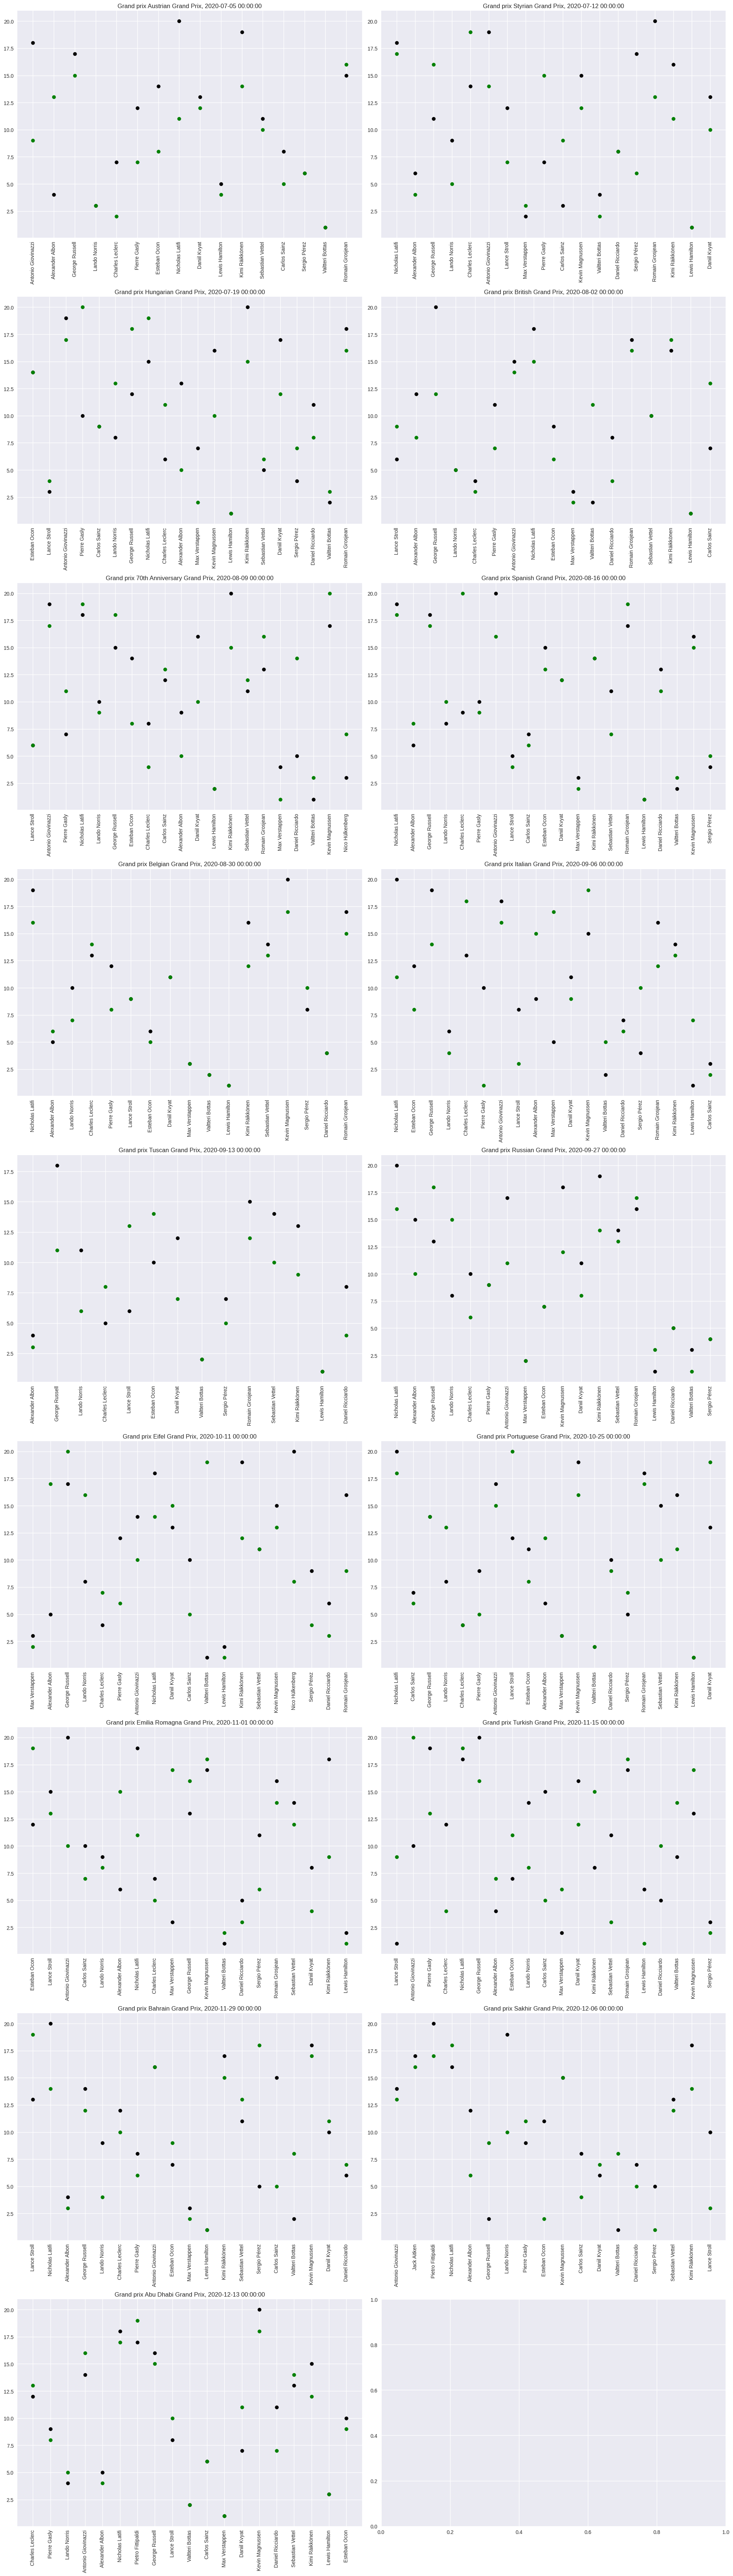

In [ ]:
graph_diff_pos_quali_pos(all_gps_2020, year2020)

In [ ]:
year2020_in_3_classes = year2020.copy()
year2020_in_3_classes["position"] = year2020_in_3_classes["position"].apply(lambda x: position_index(x)) 
year2020_in_3_classes["quali_pos"] = year2020_in_3_classes["quali_pos"].apply(lambda x: position_index(x)) 

In [ ]:
all_gps_2020_in_3_classes = year2020_in_3_classes[['GP_name', 'date']].drop_duplicates()

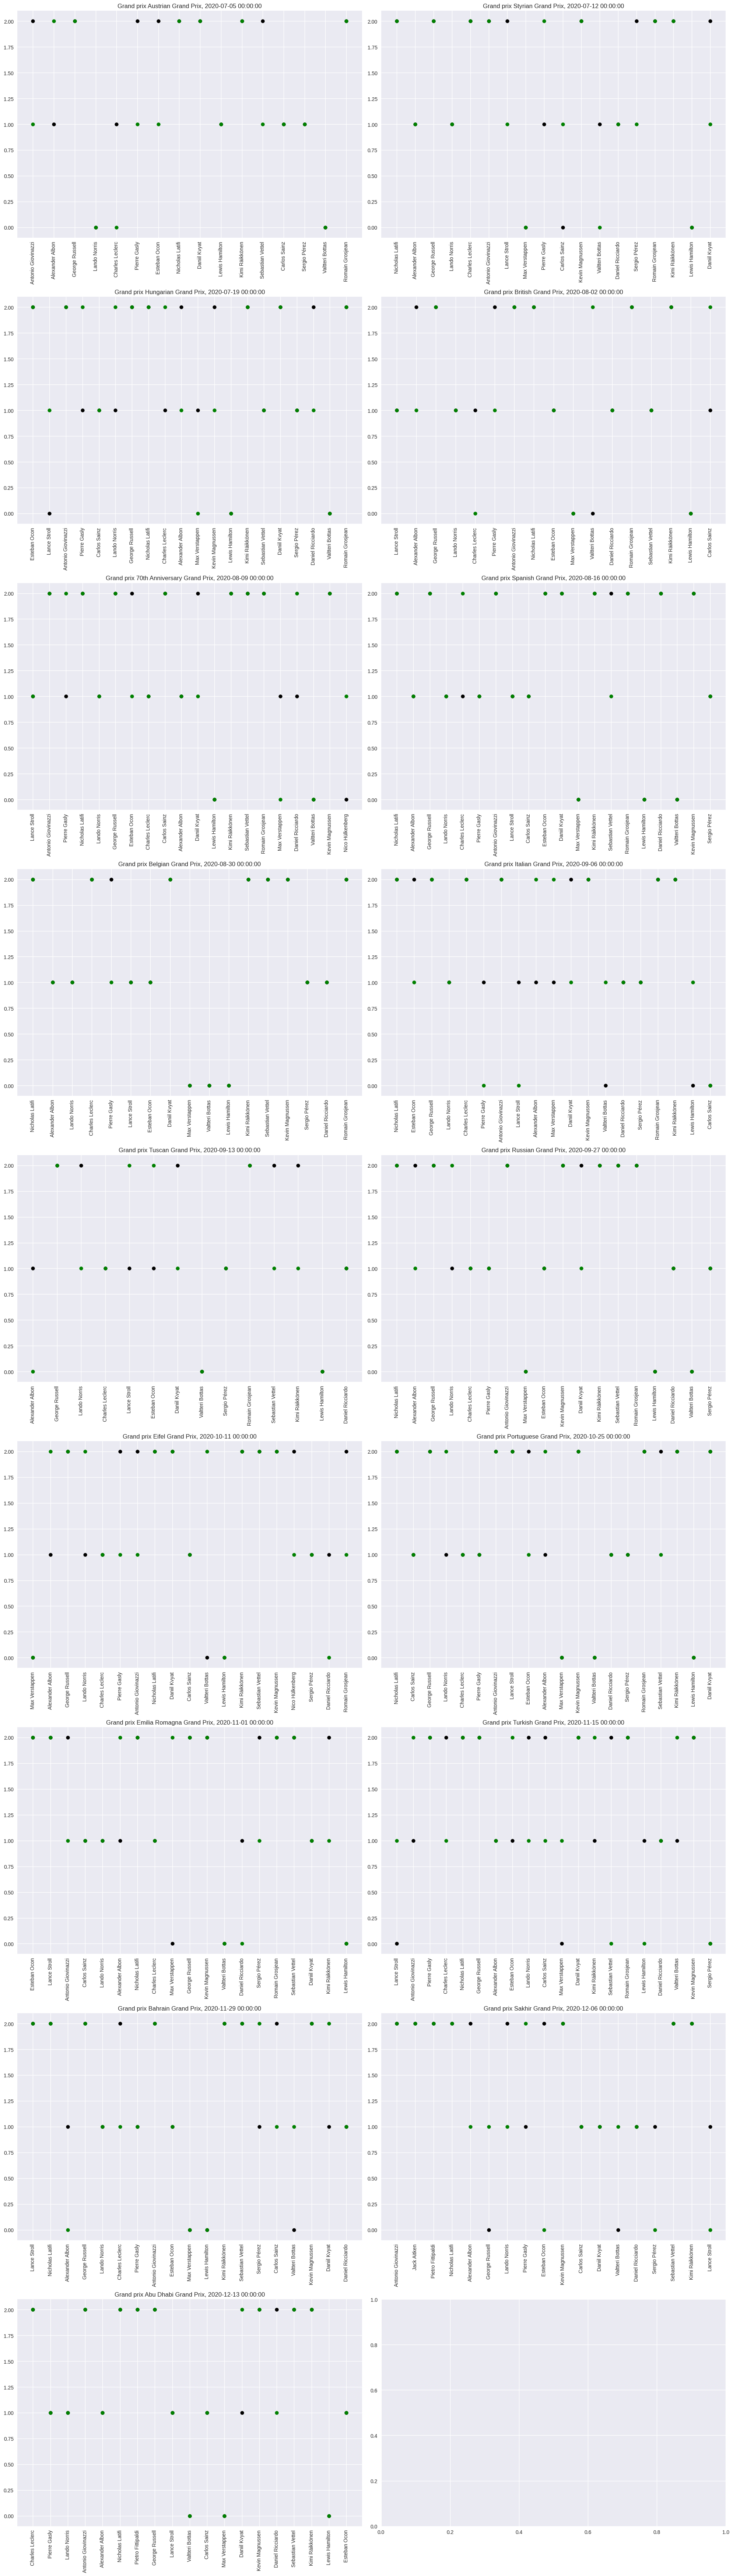

In [ ]:
graph_diff_pos_quali_pos(all_gps_2020_in_3_classes, year2020_in_3_classes)

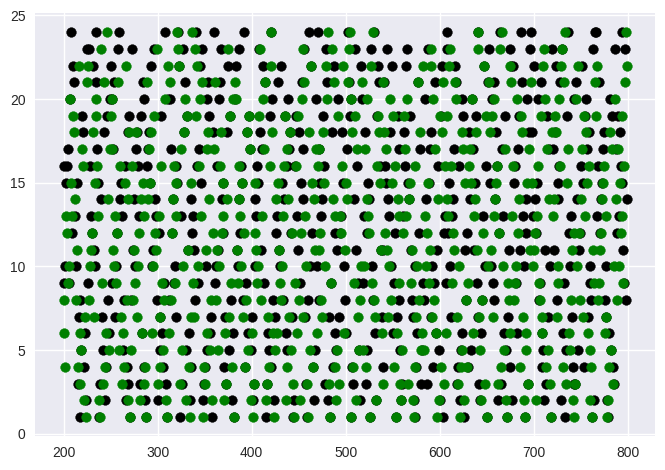

In [ ]:
fig, ax = plt.subplots()

#ax.plot(list(data.index.values.tolist())[:50], data["quali_pos"][:50], 'o', label='Graph 1')
#ax.plot(list(data.index.values.tolist())[:50], data["position"][:50], 'x', label='Graph 2') 
#ax.set_xlabel('ID')
#ax.set_ylabel('Position')
#ax.set_title('Plot of X vs Y')
#ax.grid(True)

#ax.legend()
#plt.show()

plt.scatter(list(data.index.values.tolist())[200:800], data["quali_pos"][200:800], color='k')
plt.scatter(list(data.index.values.tolist())[200:800], data["position"][200:800],color='g')
plt.show()

### Calculate the mean difference and standard deviation of changes in qualification position and position

In [ ]:
diff_quali_pos = data[["position", "quali_pos"]]
diff_quali_pos['position_3_classes'] = diff_quali_pos['position'].apply(lambda x: position_index(x))
diff_quali_pos['quali_pos_3_classes'] = diff_quali_pos['quali_pos'].apply(lambda x: position_index(x))

diff_quali_pos['diff'] = diff_quali_pos['quali_pos'] - diff_quali_pos['position']
diff_quali_pos['diff_3_classes'] = diff_quali_pos['quali_pos_3_classes'] - diff_quali_pos['position_3_classes']


In [ ]:
print(f"Unique qualification position: {diff_quali_pos['quali_pos'].unique()}")
print(f"Unqiue positions: {diff_quali_pos['position'].unique()}")

Unique qualification position: [ 2 22 14  6 12 11 17  1  4 10 16 20  8 21 19  5  7 18  3 23 13 15  9 24]
Unqiue positions: [ 2 14 10  3 11 19 16  1  6  8  9 13  7 15 18  4 17 12  5 21 22 20 23 24]


Qualification position 0?

We fixed this, before the qualification position and positions for many races were wrong, now they are correct, we did a manual validation for some races

In [ ]:
data[data['quali_pos'] == 0][["date", "GP_name", "position", "quali_pos", "driver"]]

Empty DataFrame
Columns: [date, GP_name, position, quali_pos, driver]
Index: []

In [ ]:
data[data['date'] == '2015-03-15'][['quali_pos', 'position', 'GP_name', 'date', 'driver']]

quali_pos  position                GP_name       date            driver
1653          6         6  Australian Grand Prix 2015-03-15  Daniel Ricciardo
1654          7         9  Australian Grand Prix 2015-03-15      Carlos Sainz
1655         10         5  Australian Grand Prix 2015-03-15       Felipe Nasr
1656         11        13  Australian Grand Prix 2015-03-15    Max Verstappen
1657         15         8  Australian Grand Prix 2015-03-15   Marcus Ericsson
1658         14        10  Australian Grand Prix 2015-03-15      Sergio Pérez
1659         16        11  Australian Grand Prix 2015-03-15     Jenson Button
1660          4         3  Australian Grand Prix 2015-03-15  Sebastian Vettel
1661          3         4  Australian Grand Prix 2015-03-15      Felipe Massa
1662          5        12  Australian Grand Prix 2015-03-15    Kimi Räikkönen
1663          2         2  Australian Grand Prix 2015-03-15      Nico Rosberg
1664          1         1  Australian Grand Prix 2015-03-15    Lewis Hamilton
1665         13         7  Australian Grand Prix 2015-03-15   Nico Hülkenberg

#### Analysis of difference in qualification position and position

In [ ]:
print(f"Mean: {diff_quali_pos['diff'].mean()}")
print(f"Standard deviation: {diff_quali_pos['diff'].std()}")

Mean: 0.5541604596722707
Standard deviation: 4.965589685040605


In [ ]:
print(f"Value counts:\n {diff_quali_pos['diff'].value_counts()}")
print(f"Value counts in percentage:\n {diff_quali_pos['diff'].value_counts(normalize=True)}")

Value counts:
  0     678
 1     570
 2     442
-1     410
 3     344
 4     304
-2     255
 5     241
-3     203
 6     173
-4     134
 7     134
-5     107
-7      78
-6      78
 8      77
 9      53
-9      50
-8      37
-10     36
 10     36
 11     32
-12     32
-11     25
 12     22
-13     22
-15     20
-14     19
-17     15
-16     13
 16      9
 14      9
 13      8
 15      8
-18      6
-20      5
 17      3
 18      3
 19      2
-19      2
-22      1
-21      1
-23      1
 21      1
Name: diff, dtype: int64
Value counts in percentage:
  0     0.144286
 1     0.121302
 2     0.094063
-1     0.087253
 3     0.073207
 4     0.064695
-2     0.054267
 5     0.051288
-3     0.043201
 6     0.036816
-4     0.028517
 7     0.028517
-5     0.022771
-7     0.016599
-6     0.016599
 8     0.016386
 9     0.011279
-9     0.010641
-8     0.007874
-10    0.007661
 10    0.007661
 11    0.006810
-12    0.006810
-11    0.005320
 12    0.004682
-13    0.004682
-15    0.004256
-14    0.004043

#### Box plot of difference of all data

In [ ]:
# Calculate quartiles and IQR
q1 = diff_quali_pos['diff'].quantile(0.25)
q3 = diff_quali_pos['diff'].quantile(0.75)
iqr = q3 - q1

# Define the threshold for outliers (e.g., 1.5 times the IQR)
threshold = 1.5

# Find outliers
outliers = diff_quali_pos[(diff_quali_pos['diff'] < q1 - threshold * iqr) | (diff_quali_pos['diff'] > q3 + threshold * iqr)]

# Print the outliers
outliers['diff'].unique()

array([ -8, -10,  -9, -17,  15,  14,  16, -14, -15, -20, -11,  10, -13,
        11,  19,  13, -12,  12, -18, -22, -16, -21, -23,  21, -19,  17,
        18])

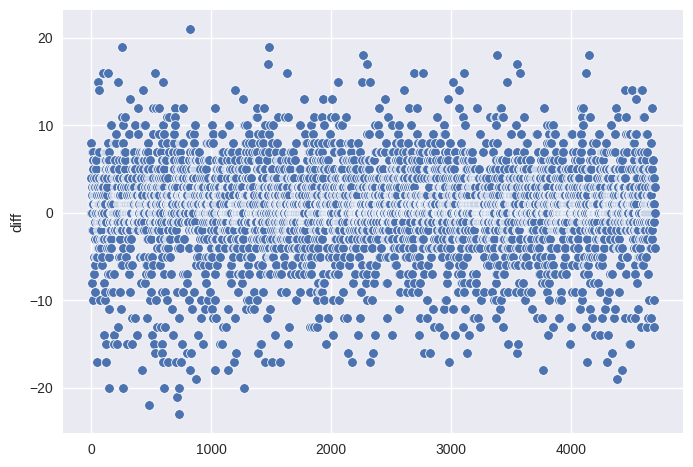

In [ ]:
sns.scatterplot(diff_quali_pos['diff'])
plt.show()

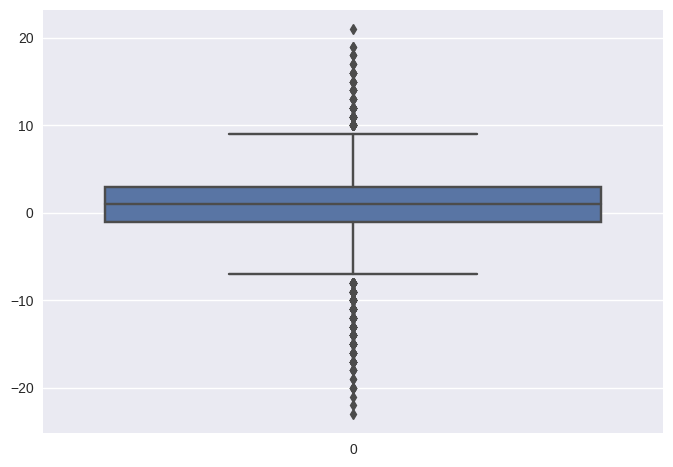

In [ ]:
sns.boxplot(diff_quali_pos['diff'])
plt.show()

#### Box plot difference by qualification position

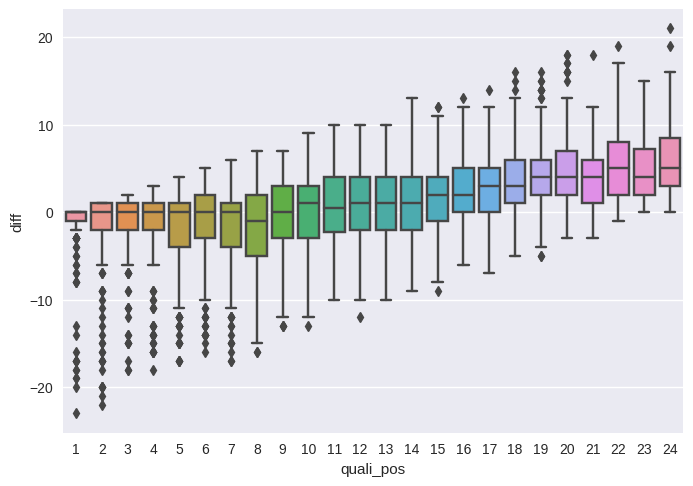

In [ ]:
sns.boxplot(diff_quali_pos, x='quali_pos', y='diff')
plt.show()

#### Analysis of difference of Qualification position and position using only 3 classes

In [ ]:
print(f"Mean of 3 classes: {diff_quali_pos['diff_3_classes'].mean()}")
print(f"Standard deviation of 3 classes: {diff_quali_pos['diff_3_classes'].std()}")

Mean of 3 classes: 0.03298574164715897
Standard deviation of 3 classes: 0.5965501805649152


In [ ]:
print(f"Value counts:\n {diff_quali_pos['diff_3_classes'].value_counts()}")
print(f"Value counts in percentage:\n {diff_quali_pos['diff_3_classes'].value_counts(normalize=True)}")

Value counts:
  0    3268
 1     774
-1     575
-2      52
 2      30
Name: diff_3_classes, dtype: int64
Value counts in percentage:
  0    0.695467
 1    0.164716
-1    0.122366
-2    0.011066
 2    0.006384
Name: diff_3_classes, dtype: float64


The models created are really bad, because a good model would get 95% of predictions correct if it only predicts the same position for the race as the qualification position

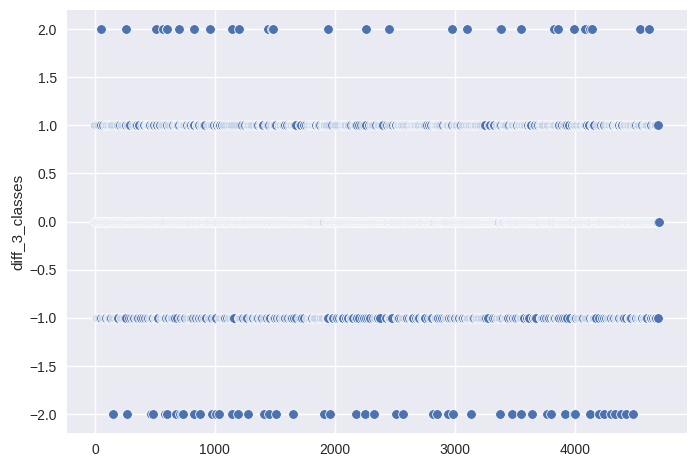

In [ ]:
sns.scatterplot(diff_quali_pos['diff_3_classes'])
plt.show()

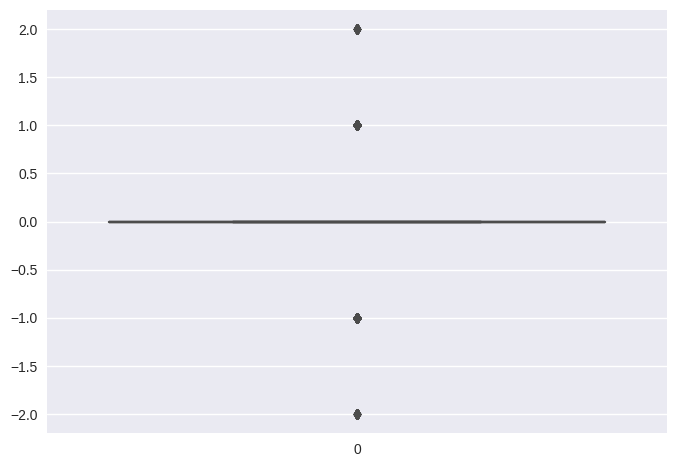

In [ ]:
sns.boxplot(diff_quali_pos['diff_3_classes'])
plt.show()

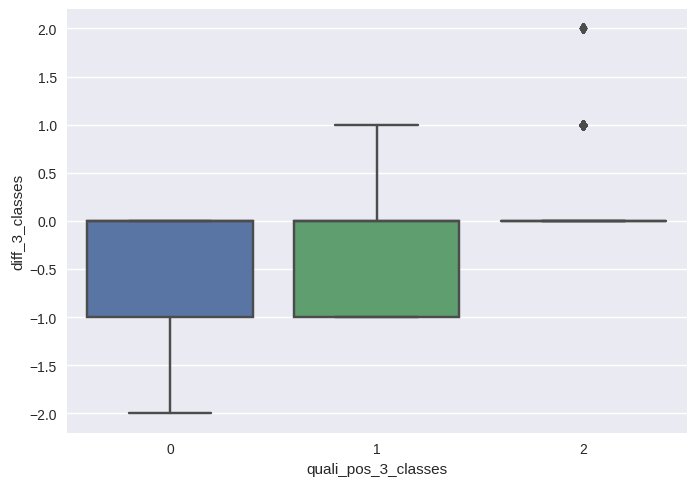

In [ ]:
sns.boxplot(diff_quali_pos, x='quali_pos_3_classes', y='diff_3_classes')
plt.show()

## Show correlation of important variables

- Pearson is linear correlation
- Kendall and spearman are non linear correlations (monotonic relationship)

In [ ]:
data_important = data[['circuitId','constructorId','driverId','quali_pos','position','wins','points','constructorPoints','constructorWins','pitStops','pitDuration','driver_confidence','constructor_reliability','weather','rain']]
data_important.dtypes

circuitId                    int64
constructorId                int64
driverId                     int64
quali_pos                    int64
position                     int64
wins                       float64
points                     float64
constructorPoints          float64
constructorWins            float64
pitStops                   float64
pitDuration                float64
driver_confidence          float64
constructor_reliability    float64
weather                    float64
rain                          bool
dtype: object

In [ ]:
new_data_important = data_important[['circuitId','constructorId','driverId','quali_pos','position','wins','points','constructorPoints','constructorWins','pitStops','pitDuration','driver_confidence','constructor_reliability','rain']]
new_data_important.head()

circuitId  constructorId  driverId  quali_pos  position  wins  points  \
0          1              1         1          2         2   0.0     0.0   
1          1            166       816         22        14   0.0     0.0   
2          1             10       814         14        10   0.0     0.0   
3          1              4       808          6         3   0.0     0.0   
4          1              5       153         12        11   0.0     0.0   

   constructorPoints  constructorWins  pitStops  pitDuration  \
0                0.0              0.0       0.0          0.0   
1                0.0              0.0       0.0          0.0   
2                0.0              0.0       0.0          0.0   
3                0.0              0.0       0.0          0.0   
4                0.0              0.0       0.0          0.0   

   driver_confidence  constructor_reliability   rain  
0                0.0                      0.0  False  
1                0.0                      0.0  False  
2                0.0                      0.0  False  
3                0.0                      0.0  False  
4                0.0                      0.0  False

La correlacion inversa de driver_confidence y constructor reliability nos dice que entre mejor confidence y reliability, mejor posicion tendremos en la carrera

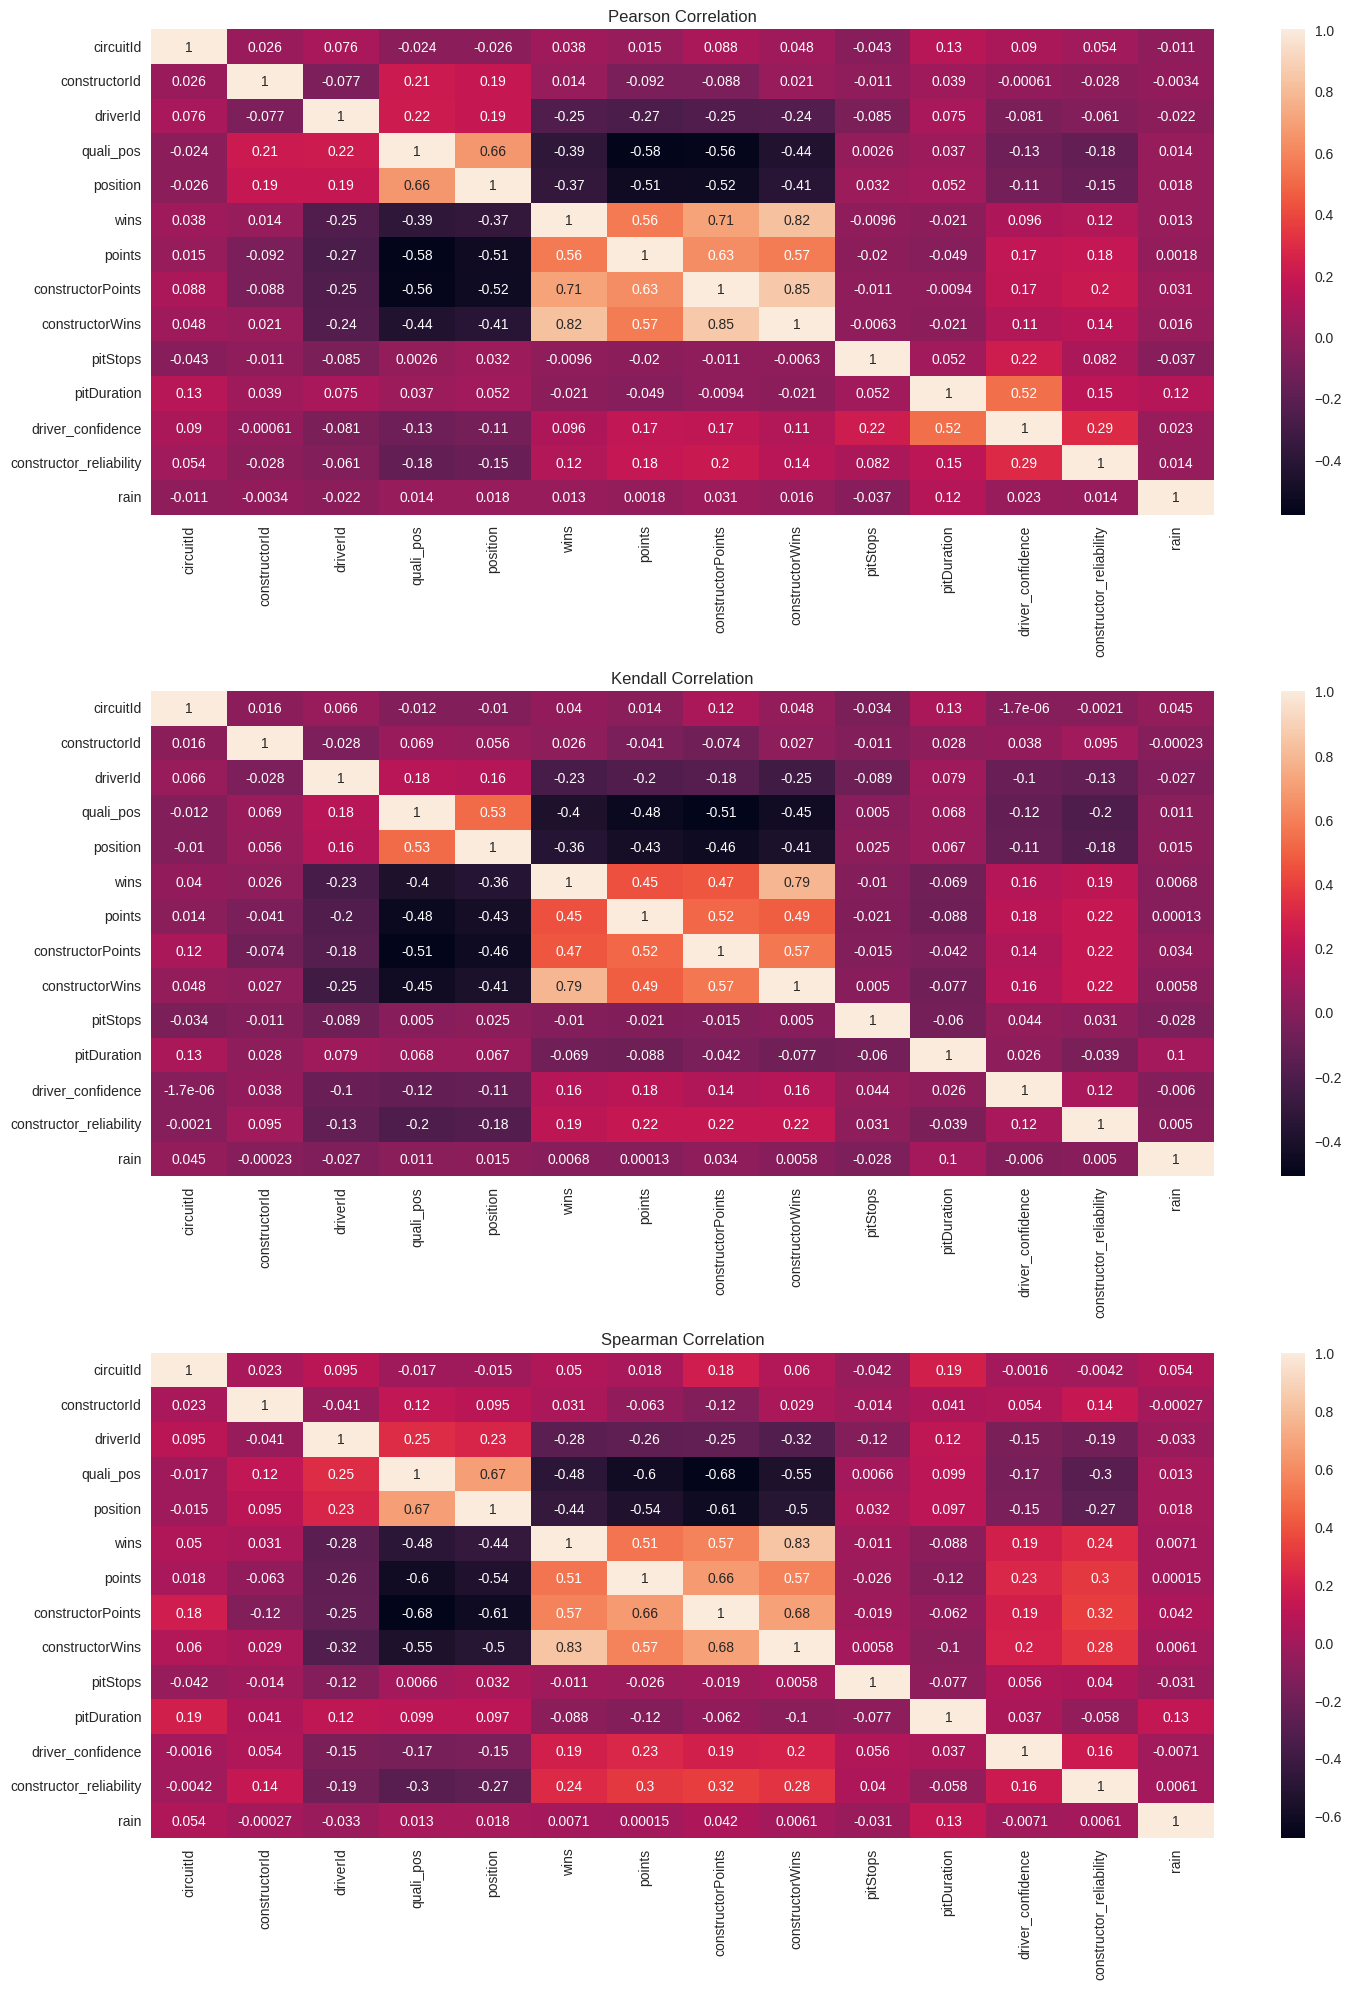

In [ ]:
showCorrelation(new_data_important, nCols=1)

### Do a correlation study of all variables in the dataset

In [ ]:
# data["label"] = pd.factorize(data["driver_nationality"])[0]
data['DateFactorized'] = pd.factorize(data['date'])[0]
data["DateFactorized"].head

<bound method NDFrame.head of 0         0
1         0
2         0
3         0
4         0
       ... 
4694    238
4695    238
4696    238
4697    238
4698    238
Name: DateFactorized, Length: 4699, dtype: int64>

In [ ]:
data.dtypes

Unnamed: 0                          int64
year                                int64
date                       datetime64[ns]
GP_name                            object
raceId                              int64
circuitId                           int64
driverId                            int64
constructorId                       int64
driver                             object
constructor                        object
position                            int64
quali_pos                           int64
wins                              float64
points                            float64
constructorPoints                 float64
constructorWins                   float64
driver_home                        object
statusId                            int64
pitStops                          float64
pitDuration                       float64
GP_name.1                          object
constructor_dnf                     int64
driver_dnf                          int64
constructor_reliability           

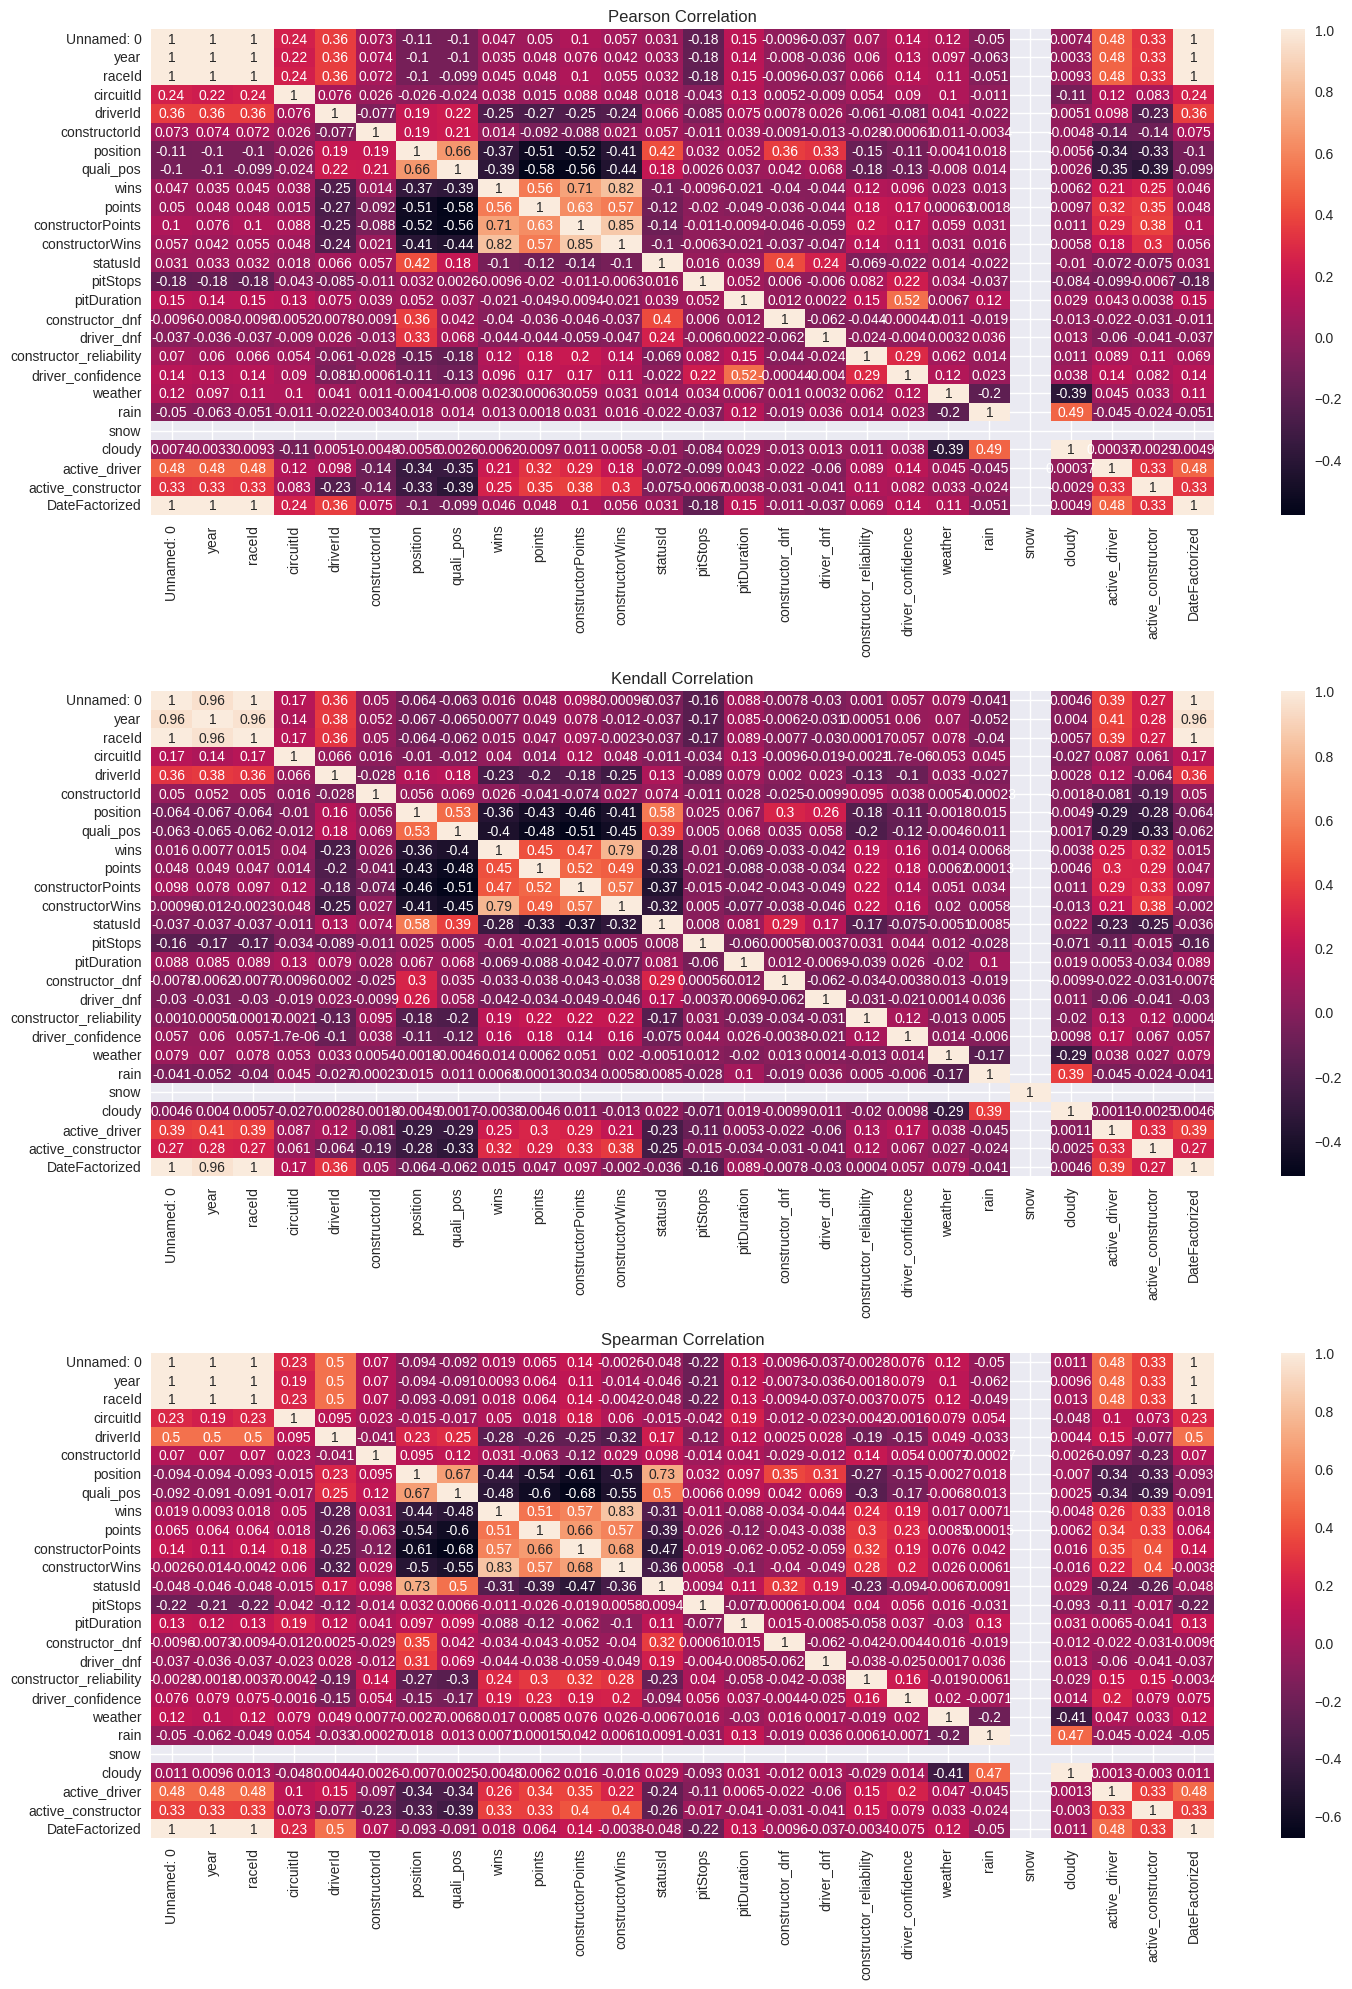

In [ ]:
showCorrelation(data, nCols=1)

## Pairplot of important data

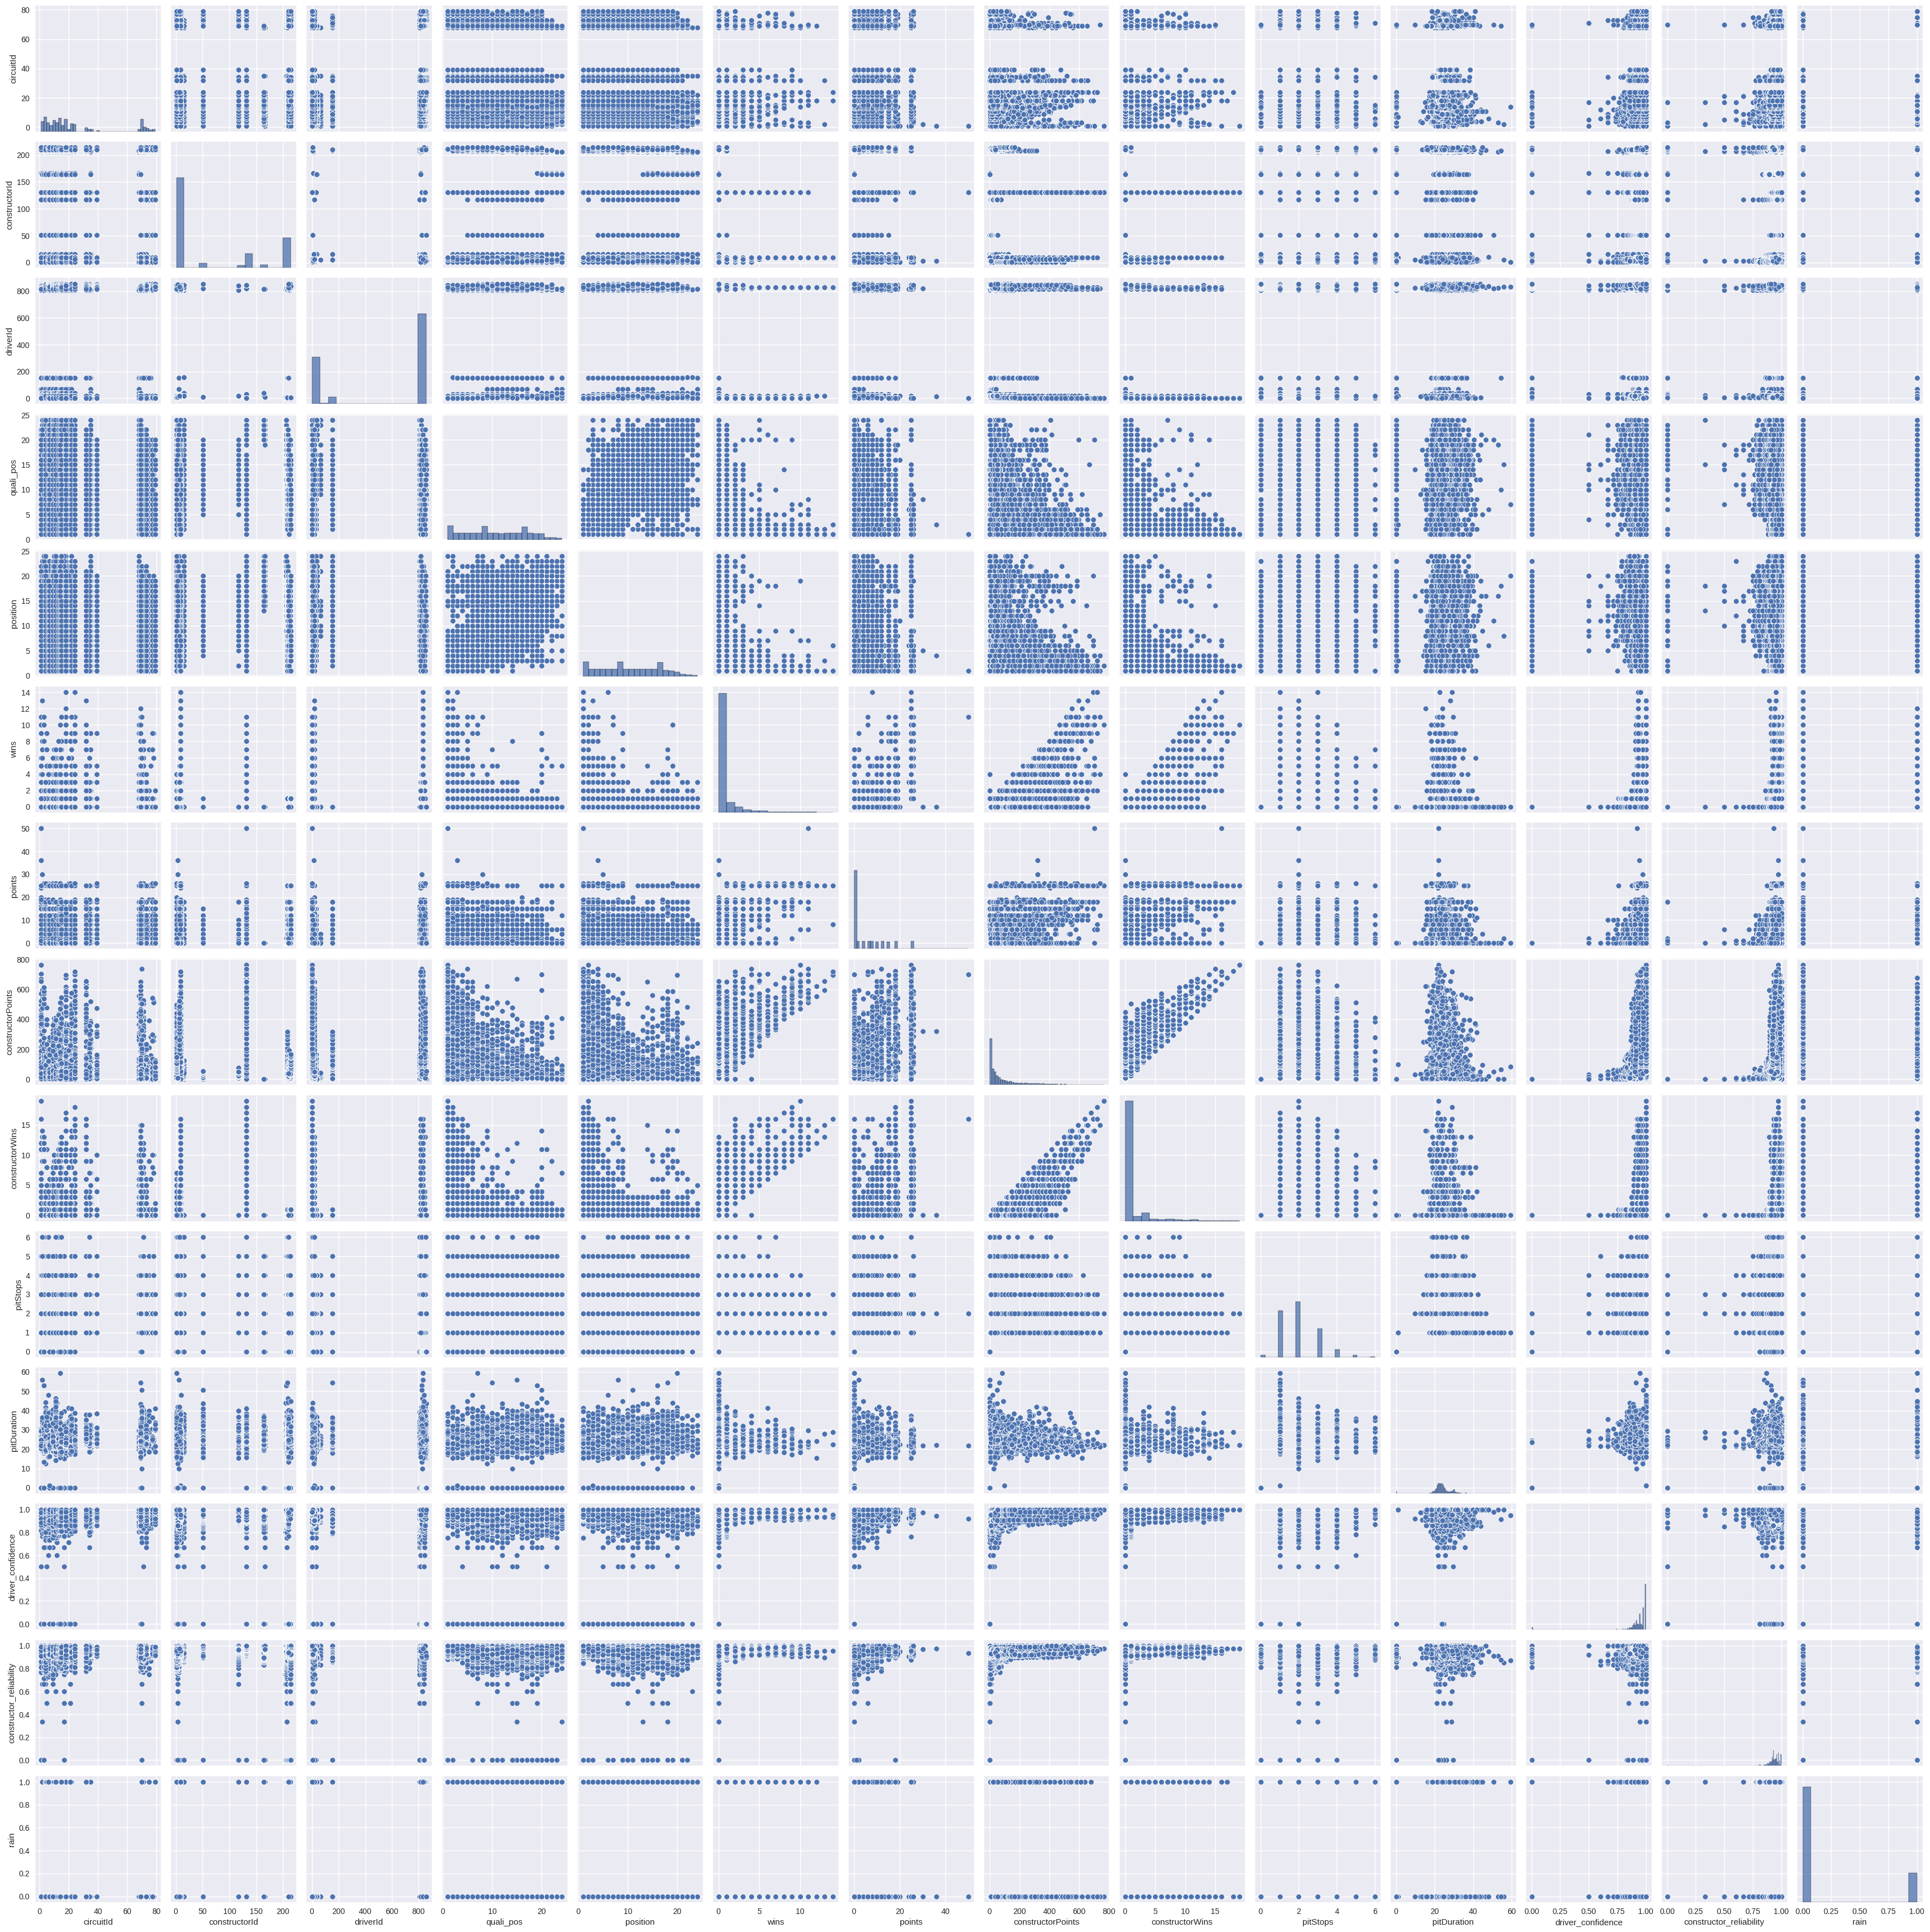

In [ ]:
sns.pairplot(new_data_important)
plt.show()

## Distribution plot of important data

In [ ]:
def distribution_plot(data_df, num_cols=1):
  num_cols = num_cols  # Number of columns in each row
  num_rows = (len(data_df.columns) - 1) // num_cols + 1  # Calculate the number of rows

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(35, 5*num_rows))  # Adjust the figsize as per your preference

  for i, column in enumerate(data_df.columns):
      ax = axes[i // num_cols, i % num_cols]  # Get the appropriate subplot axes
      sns.histplot(data_df[column], ax=ax)
      ax.set_title(f"Distribution of {column}")
      ax.set_xlabel("Values")
      ax.set_ylabel("Frequency")

  plt.tight_layout()  # Adjust the spacing between subplots
  plt.show()

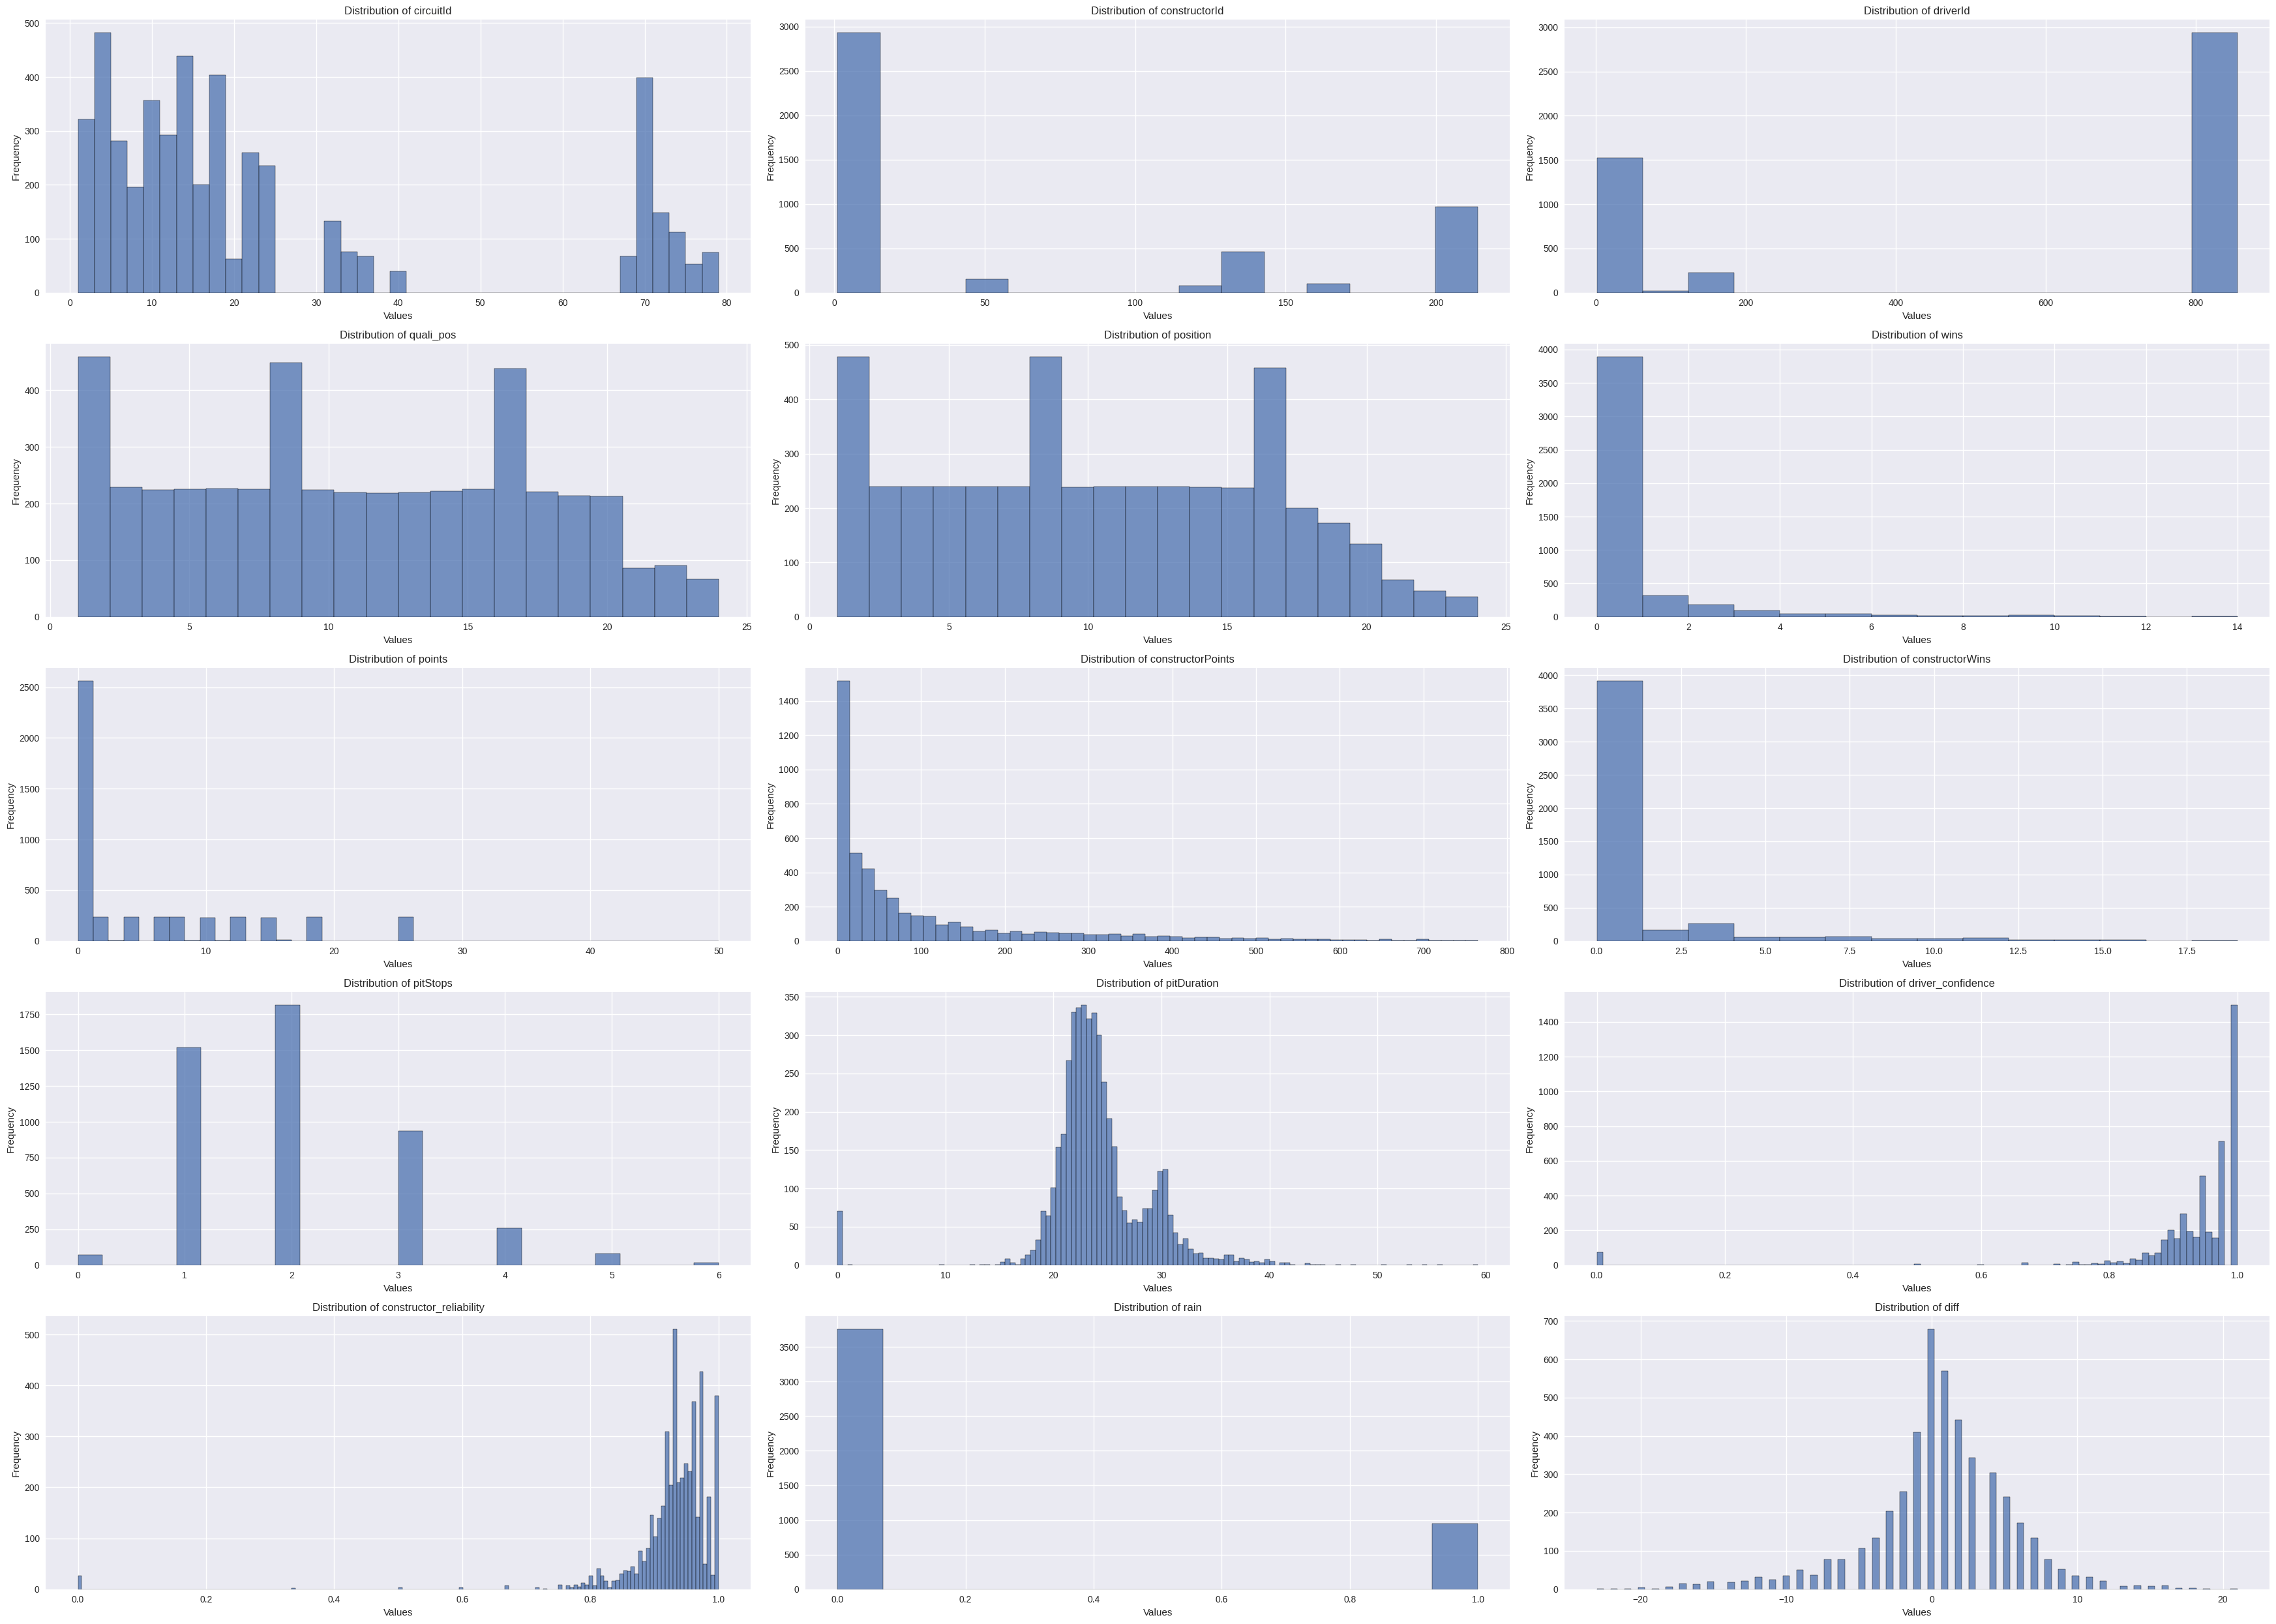

In [ ]:
new_data_with_diff_pos = new_data_important.copy()
new_data_with_diff_pos['diff'] = new_data_with_diff_pos['quali_pos'] - new_data_with_diff_pos['position']
distribution_plot(new_data_with_diff_pos, 3)